## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

pnp_dataset.zip


In [2]:
import matplotlib.pyplot as plt

In [3]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728855944.021518      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728855944.070184      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728855944.071868      28 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [56]:
from collegium.m02_cnn.utils.pnp_dataset import build_dataset

train_ds = build_dataset('train', include_labels=True)
score_ds = build_dataset('score', include_labels=False)

# Number of samples for training, validation, and testing
validation_size = 10000
test_size = 5000
total_train_size = 70000

# Split train_ds into training and validation datasets
validation_ds = train_ds.take(validation_size)
train_ds = train_ds.skip(validation_size)

# Further split validation_ds to create a test dataset
test_ds = validation_ds.take(test_size)
validation_ds = validation_ds.skip(test_size)

# Batch the datasets
batch_size = 512
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
validation_size = 5000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


<tf.Tensor: shape=(), dtype=int32, numpy=1>

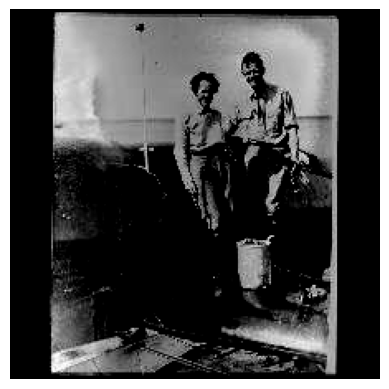

In [4]:
train_sample_x, train_sample_y = next(iter(train_ds))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


<tf.Tensor: shape=(), dtype=int32, numpy=0>

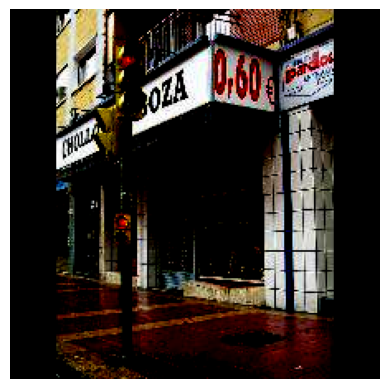

In [5]:
train_sample_x, train_sample_y = next(iter(train_ds.skip(1)))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

In [69]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
from tensorflow.keras.layers import Input, Dense, AvgPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import applications  



efficient_net = applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    name="efficientnetv2-b3"
)

In [70]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
efficient_net.trainable = False

In [7]:
efficient_net.summary()

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,930,622 (49.33 MB)

In [71]:
model = Sequential([
    efficient_net,
    GlobalAveragePooling2D(), 
    Dense(units=512, activation='relu'),  
    BatchNormalization(),
    Dense(units=128, activation='relu'),  
    BatchNormalization(),
    Dense(units=32, activation='relu'),  
    BatchNormalization(),
    Dense(units=1)  
])

In [38]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,790,079 (52.60 MB)

 Trainable params: 858,113 (3.27 MB)

 Non-trainable params: 12,931,966 (49.33 MB)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras import metrics

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if no improvement in validation loss for 5 epochs
    restore_best_weights=True
)

# Cosine learning rate decay schedule
def cosine_decay_schedule(initial_lr, global_step, decay_steps):
    cosine_decay = 0.5 * (1 + np.cos(np.pi * global_step / decay_steps))
    return initial_lr * cosine_decay

# Training loop with early stopping and learning rate scheduling
learning_rates = [0.001, 0.003, 0.01, 0.03]
epochs = 30  
decay_steps = 126 * epochs  # Total steps in training



lr = 0.003
optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)]
)

def scheduler(epoch, current_lr):
    # After 10 epochs, use cosine decay based on the original lr
        global_step = epoch * 126  # Steps after epoch 10
        return cosine_decay_schedule(lr, global_step, decay_steps)

lr_scheduler = LearningRateScheduler(scheduler)
    

In [73]:
import numpy as np
import tensorflow as tf

np.random.seed(12)
tf.random.set_seed(12)
model.fit(
    train_ds,  # Batched training dataset (images and labels)
    epochs=epochs,
    steps_per_epoch=(total_train_size - validation_size) // batch_size,  # Calculate steps per epoch
    callbacks=[early_stopping, lr_scheduler],
    validation_data=validation_ds  # Batched validation dataset (images and labels)
)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.6245 - loss: 4.0528

/app/conda/envs/collegium/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


126/126 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - binary_accuracy: 0.6250 - loss: 4.0434 - val_binary_accuracy: 0.7950 - val_loss: 0.5084 - learning_rate: 0.0030
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - binary_accuracy: 0.7709 - loss: 1.0257 - val_binary_accuracy: 0.8004 - val_loss: 0.5007 - learning_rate: 0.0030
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - binary_accuracy: 0.7950 - loss: 0.6159 - val_binary_accuracy: 0.8476 - val_loss: 0.3894 - learning_rate: 0.0030
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 249ms/step - binary_accuracy: 0.8347 - loss: 0.4433 - val_binary_accuracy: 0.8510 - val_loss: 0.3929 - learning_rate: 0.0029
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - binary_accuracy: 0.8437 - loss: 0.4348 - val_binary_accuracy: 0.8592 - val_loss: 0.3863 - learning_rate: 0.0029
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 270ms/step - binary_accuracy: 0.8508 - loss: 0.4261 - val_binary_accuracy: 0.8594 - val_loss: 0.3993 - learning_rate: 0.0028
Epo

In [74]:

test_loss, test_accuracy = model.evaluate(test_ds)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - binary_accuracy: 0.8809 - loss: 0.3691
Test Loss: 0.35494592785835266
Test Accuracy: 0.8809999823570251


In [75]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)


score_y_hat = pd.DataFrame(
    model.predict(score_ds.batch(batch_size)),
    
    columns=['score']
)


score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')
assert score_y_hat.shape == (20000, 1)


import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))


tf.keras.models.save_model(model, f'{model_dir}/model.keras')



40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
